In [1]:
%matplotlib inline
# %matplotlib notebook

from __future__ import print_function

try:
    from importlib import reload
except:
    pass

import os
import sys
import warnings

import numpy as np
import pandas as pd
import astropy as ap
import sfdmap

import sqlite3
from sqlalchemy import create_engine

from matplotlib import pyplot as plt
import matplotlib.colors as mpl_colors 

import astropy.units as u

In [2]:
import pyCoCo as pccsims
import pycoco as pcc

reload(pcc)
reload(pcc.defaults)
reload(pcc.kcorr)
reload(pcc.classes)
reload(pccsims)

<module 'pyCoCo' from '/Users/berto/Code/CoCo/pyCoCo.cpython-36m-darwin.so'>

In [3]:
# %%timeit ## 1 loop, best of 3: 1min 31s per loop 
opsimdbpath = os.environ.get('OPSIMDBPATH')
print(opsimdbpath)
# opsimdbpath = "/Users/berto/data/LSST/OpSimOutputDBs/astro_lsst_01_1068_sqlite.db"
# opsimdbpath = "/Users/berto/data/LSST/OpSimOutputDBs/minion_1016_sqlite.db"

conn = create_engine('sqlite:///'+opsimdbpath, echo = False)
# opsimdf = pd.read_sql_table('Summary', con=conn)

/Users/berto/data/LSST/OpSimOutputDBs/minion_1016_sqlite.db


In [4]:
opsimdf = pd.read_sql_query(sql = "SELECT * FROM Summary WHERE night > 365 AND night < 731", con = conn)

opsimdf.columns

In [5]:
opsimdf.columns

Index(['obsHistID', 'sessionID', 'propID', 'fieldID', 'fieldRA', 'fieldDec',
       'filter', 'expDate', 'expMJD', 'night', 'visitTime', 'visitExpTime',
       'finRank', 'FWHMeff', 'FWHMgeom', 'transparency', 'airmass',
       'vSkyBright', 'filtSkyBrightness', 'rotSkyPos', 'rotTelPos', 'lst',
       'altitude', 'azimuth', 'dist2Moon', 'solarElong', 'moonRA', 'moonDec',
       'moonAlt', 'moonAZ', 'moonPhase', 'sunAlt', 'sunAz', 'phaseAngle',
       'rScatter', 'mieScatter', 'moonIllum', 'moonBright', 'darkBright',
       'rawSeeing', 'wind', 'humidity', 'slewDist', 'slewTime',
       'fiveSigmaDepth', 'ditheredRA', 'ditheredDec'],
      dtype='object')

Load in the Atmosphere

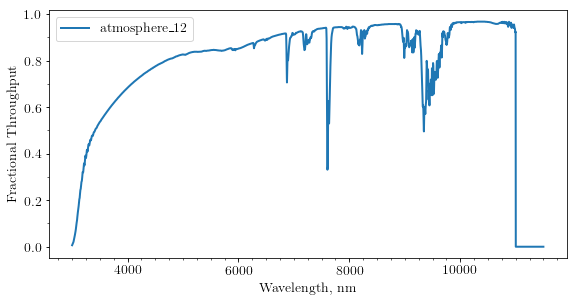

In [6]:
# atmos = pcc.kcorr.load_atmosphere()
path = os.path.join(pcc._default_lsst_throughputs_path, "baseline/atmos_std.dat")
atmos = pcc.BaseFilterClass()
atmos.load(path, wavelength_u = u.nm, fmt = "ascii.commented_header", name = "atmosphere_12")
atmos.plot()

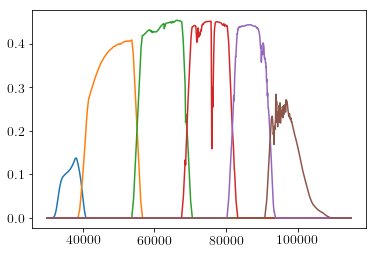

In [7]:
lsst_filters = ["LSST_u", "LSST_g", "LSST_r", "LSST_i", "LSST_z", "LSST_y"]

fdict = {}

for filter_name in lsst_filters:
    filter_path = os.path.join(pcc._default_filter_dir_path, filter_name + ".dat")
#     filter_path = os.path.join("/Users/berto/projects/LSST/throughputs/baseline/", filter_name + ".dat")
#     fdict[filter_name] = pcc.load_filter(filter_path)    
    fdict[filter_name] = pcc.FilterClass()
    fdict[filter_name].load(filter_path, wavelength_u = u.nm)
#     pcc.load_filter(filter_path)    

fig = plt.figure()

ax1 = fig.add_subplot(111)

for filter_name in lsst_filters:
    plt.plot(fdict[filter_name].data["wavelength"], fdict[filter_name].data["throughput"])
plt.show()

Load in the sky spectrum

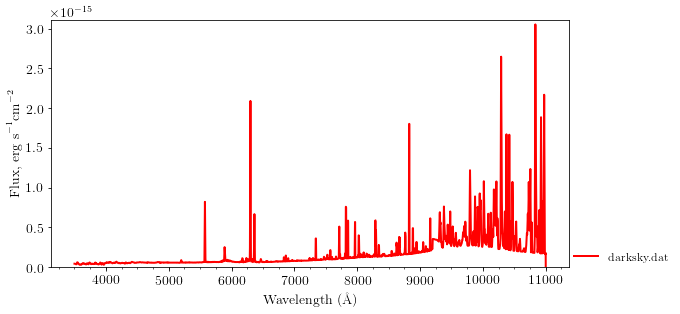

In [8]:
dark_sky_path = os.path.join(os.environ["LSST_THROUGHPUTS_BASELINE"],"darksky.dat")
darksky = pcc.SpectrumClass()
darksky.load(dark_sky_path, wavelength_u = u.nm, fmt = "ascii.commented_header", wmin = 3500*u.angstrom, wmax = 11000*u.angstrom,)
darksky.plot()

Which is equivalent to:

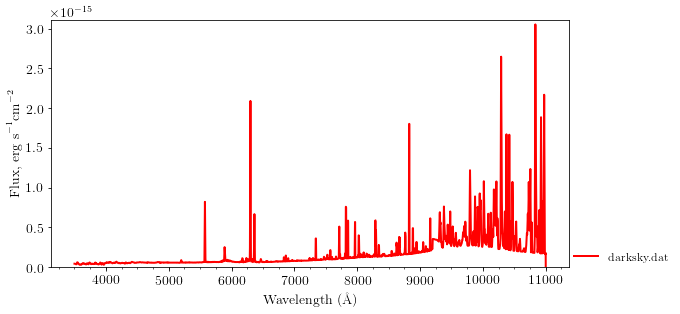

In [9]:
darksky = pcc.kcorr.load_dark_sky_spectrum()
darksky.plot()

In [14]:
lsst_filters = ["LSST_u", "LSST_g", "LSST_r", "LSST_i", "LSST_z", "LSST_y"]

for filter_name in lsst_filters:
    zp = pcc.kcorr.calc_AB_zp(filter_name)
    print(filter_name, " F_sky = ", pcc.kcorr.calc_spectrum_filter_flux(filter_name, darksky))
    print(filter_name, "zp = ",zp)        
    print(filter_name, "m_sky = ", -2.5 * np.log10(pcc.kcorr.calc_spectrum_filter_flux(filter_name, darksky)) - zp)    

LSST_u  F_sky =  4.45069464694e-17
LSST_u zp =  20.568109995
LSST_u m_sky =  20.3108205069
LSST_g  F_sky =  6.01879161433e-17
LSST_g zp =  20.8004756443
LSST_g m_sky =  19.7507510877
LSST_r  F_sky =  9.38051759036e-17
LSST_r zp =  21.3643486135
LSST_r m_sky =  18.705084381
LSST_i  F_sky =  1.23467612028e-16
LSST_i zp =  21.7913782321
LSST_i m_sky =  17.9797391464
LSST_z  F_sky =  2.0648151069e-16
LSST_z zp =  22.0957429073
LSST_z m_sky =  17.1170541703
LSST_y  F_sky =  4.12923644148e-16
LSST_y zp =  22.3299942369
LSST_y m_sky =  16.1303313845


Create a df that just looks at the first observation in each filter

In [11]:
opsimdf_f = opsimdf.drop_duplicates("filter")

opsimdf_f

,obsHistID,sessionID,propID,fieldID,fieldRA,fieldDec,filter,expDate,expMJD,night,...,moonBright,darkBright,rawSeeing,wind,humidity,slewDist,slewTime,fiveSigmaDepth,ditheredRA,ditheredDec
0,263142,1016,54,2061,0.000000,-0.219248,y,31625330,59946.033917,366,...,462.691430,100.946739,0.561796,0.0,0.0,0.219248,0.0,21.448681,6.261672,-0.209329
133,263275,1016,54,995,1.948142,-0.674642,i,31631051,59946.100129,366,...,281.413641,95.087870,0.795142,0.0,0.0,0.167435,120.0,22.916259,1.921254,-0.664723
679,263821,1016,54,2446,1.392602,-0.079882,z,31711738,59947.034016,367,...,887.948946,99.921028,0.576039,0.0,0.0,1.393176,0.0,21.924364,1.375366,-0.069963
1308,264450,1016,55,2786,2.624318,0.049506,r,31737144,59947.328060,367,...,1.976780,90.830641,0.874450,0.0,0.0,0.928216,140.0,23.944850,2.607116,0.059425
1329,264470,1016,56,2786,2.624318,0.049506,g,31737982,59947.337759,367,...,0.000000,90.899902,0.975894,0.0,0.0,0.000000,120.0,24.125418,2.607116,0.059425
10874,274014,1016,54,1554,1.857529,-0.429166,u,33182853,59964.060804,384,...,0.000000,90.635719,0.697750,0.0,0.0,0.885411,120.0,23.108736,1.853330,-0.415940


In [12]:
opsimdf_f[["filter", "filtSkyBrightness", "darkBright"]]

,filter,filtSkyBrightness,darkBright
0,y,17.000000,100.946739
133,i,19.111039,95.087870
679,z,17.000000,99.921028
1308,r,21.132191,90.830641
1329,g,21.844739,90.899902
10874,u,22.097899,90.635719


# OpSim m5 derivation 

Recreating the m5 values, as per http://smtn-002.lsst.io/en/latest/

\begin{split}m5 = C_m + dC_m + 0.50\,(m_{sky} - 21.0) + 2.5 log_{10}(0.7 /
FWHM_{eff}) \\
+ 1.25 log_{10}(expTime / 30.0) - k_{atm}\,(X-1.0)\end{split}

\begin{split}dC_m = dC_m^{inf} - 1.25 log_{10}(1 + (10^{(0.8\, dC_m^{inf} -
1)}/Tscale)\end{split}

\begin{split}Tscale = expTime / 30.0 * 10.0^{-0.4*(m_{sky} - m_{darksky})}\end{split}


In [13]:
def calc_Tscale(df):
    Tscale = df["visitExpTime"].head()/30. * np.power(10., -0.4*())
    return Tscale


def calc_dCm():
    dCm = False
    return dCm


def calc_m5():
    m5 = False
    return m5

